# Solving the Shallow Water Equations using Finite Volumes and Lax-Friedrichs
---
Nathan Brei

Technical University of Munich

14 December 2017


# Shallow Water Equations (1-D)
Mass and momentum conservation on a fluid in a channel of unit width
* Assume negligible vertical velocity
* Assume constant horizontal velocity $u(x)$ across any cross section $x$
* Assume pressure is determined by hydrostatic pressure $p=\frac{1}{2}\rho gh^2$

$\begin{bmatrix}h \\ hu \end{bmatrix}_t + \begin{bmatrix}hu \\ hu^2 + \frac{1}{2}gh^2\end{bmatrix}_x = 0 $

Formulate as a general conservation law in differential form: $q_t(x,t) + f(q(x,t))_x = 0$

$q := (h, hu) \in Q$

$f : (q_1, q_2) \mapsto \begin{bmatrix} q_2\\ q_2^2/q_1 + \frac{1}{2}gq_1^2\end{bmatrix}$


# Shallow Water Equations (1-D)
Formulate as a general conservation law in differential form: $q_t(x,t) + f(q(x,t))_x = 0$

$q := (h, hu) \in Q$

$f : (q_1, q_2) \mapsto \begin{bmatrix} q_2\\ q_2^2/q_1 + \frac{1}{2}gq_1^2\end{bmatrix}$


In [224]:
const Float = Float64
const G = 9.81f0

mutable struct Q
    h :: Float
    hu :: Float
end

function f(q :: Q)
    Q(q.hu, q.hu^2/q.h + 0.5*G*q.h^2)
end

f (generic function with 1 method)

## Types and Methods in Julia

* Types are composed of primitives, structures, unions, tuples, abstract types
* Inheritance is restricted to abstract types
* Encapsulation is achieved via the module system, not the type system
* Invariants are enforced via immutability and internal constructors
* Types are parametric
* Type annotations are optional
* Methods resolved via multiple dispatch (using all arguments rather than the first)
* Methods can be added in a piecewise fashion

## Defining a vector space over Q

In [227]:
import Base.+
import Base.-
import Base.*

function +(lhs::Q, rhs::Q)
    Q(lhs.h + rhs.h, lhs.hu + rhs.hu)
end

function -(lhs::Q, rhs::Q)
    Q(lhs.h + rhs.h, lhs.hu + rhs.hu)
end

function *(a::Real, q::Q)
    Q(a*q.h, a*q.hu)
end

* (generic function with 215 methods)

## CFL Condition
* Necessary condition for numerical stability
* Information propagates through the spatial domain at finite speeds
* Ensure that {physical domain of dependence} $\subset$ {numerical domain of dependence}

$ \nu := \lvert\frac{\bar{u}\Delta t}{\Delta x} \rvert = \frac{\Delta t}{\Delta x} \lvert \lambda_{max} \rvert  \leq 1 $

* Physical speeds determined by dominant eigenvalue of flux Jacobian
* Only need magnitude, not direction

$f'(q) = \begin{bmatrix}0 & 1 \\ -u^2 + gh & 2u \end{bmatrix}$

$\lambda_{max} = \max\ \lvert u \pm \sqrt{gh} \rvert$



In [228]:
function wavespeed(q :: Q)
    u = q.hu / q.h
    c = sqrt(G * q.h)
    max(abs(u-c), abs(u+c))
end

function cfl_dt(dx::Float, wavespeed::Float, correction::Float)
    dx / wavespeed * correction
end

cfl_dt (generic function with 1 method)

# Introduction to finite volumes => Godunov => Lax-Friedrichs

STILL NEED THIS!!!

In [ ]:
function updateqs!(qs::Array{Q,1}, Fl::Array{Q,1}, Fr::Array{Q,1}, 
                   ncells::Int, dx::Float, dt::Float
    
    for x = 2:ncells+1
        q = qs[x]
        qs[x] = Q(q.h  - dt/dx * (Fr[x].h  + Fl[x-1].h),
                  q.hu - dt/dx * (Fr[x].hu + Fl[x-1].hu))
    end


# Lax-Friedrichs Solver
* Input:  Buffers for $q(x), F_l(x), F_r(x)$, cell and timestep sizes
* Output: Buffers updated by one timestep

In [221]:
function lxf!(qs::Array{Q,1}, Fl::Array{Q,1}, Fr::Array{Q,1}, 
              ncells::Int, dx::Float, dt::Float)
    
    a = dx/dt
    for x = 2:ncells+2
        ql, qr = qs[x-1], qs[x]
        fl, fr = f(ql), f(qr)
        
        Fr[x-1] = Q(0.5*((fr.h  - fl.h)  - a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) - a*(qr.hu - ql.hu)))
        Fl[x-1] = Q(0.5*((fr.h  - fl.h)  + a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) + a*(qr.hu - ql.hu)));
    end
end

lxf! (generic function with 2 methods)

# Timestepping loop


In [223]:
function run_experiment(stoptime, ncells::Int, safetyfactor::Float, 
                        apply_bcs!, apply_ics)

    qs = apply_ics(ncells)
    Fl = Array{Q,1}(ncells+2)
    Fr = Array{Q,1}(ncells+2)

    currenttime = 0
    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        lambda = qs |> wavespeed |> maximum
        dt = cfl_dt(dx, lambda, safetyfactor)
        lxf!(qs, Fl, Fr, ncells, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment (generic function with 2 methods)

# Timestepping loop for animations
* Global timesteps correspond to increments of physical time and animation frames
* An outer loop controls global timesteps by iterating over stoptime
* Local timesteps correspond to increments of dt
* Local timesteps go up to stoptime exactly

In [98]:
function run_experiment!(qs, Fl, Fr, currenttime, stoptime,
                         ncells::Int, is_local::Bool, penalty::Float, apply_bcs!)

    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        lambda = maximum(map(wavespeed, qs))
        dt = cfl_dt(dx, lambda, penalty)
        if currenttime + dt > stoptime
            dt = stoptime - currenttime
        end
        lxf!(qs, Fl, Fr, ncells, is_local, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment! (generic function with 2 methods)

In [7]:
# Set up plotting infrastructure
using Plots
pyplot()

function plotxh(qs, title)
    plot(map(q->q.h, qs), title=title, xlabel="x", ylabel="h", ylim=(0.,2.5))
end

function plotxhul(qs, title)
    p0 = plot(map(q->q.h, qs), xlabel="x", ylabel="h", title=title)
    p1 = plot(map(q->q.hu, qs), xlabel="x", ylabel="hu")
    p2 = plot(map(wavespeed, qs), xlabel="x", ylabel="\$\\lambda_{max}\$")
    plot(p0,p1,p2,layout=(3,1),legend=false)
end

function plotxhs(qss, labels, title)
    p = plot(title=title, xlabel="x", ylabel="h", ylim=(0.,2.5))
    for i=1:length(qss)
        x = linspace(0,1,length(qss[i])-2)
        plot!(x, map(q->q.h, qss[i]), label=labels[i])
    end
    p
end

function plotxh(title)
    plot(title=title, xlabel="x", ylabel="h", ylim=(0.,2.5))
end

function plotxh!(p, qs, label)
    xs = linspace(0,1,length(qs))
    hs = map(q->q.h, qs)
    plot!(p, xs, hs, label=label)
end
    


plotxh! (generic function with 1 method)

# Gaussian Initial Condition


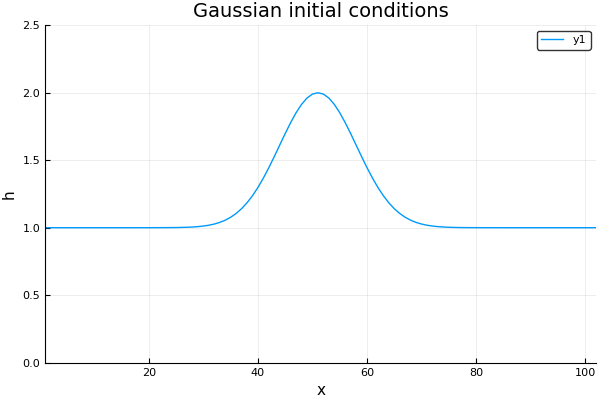

In [8]:
function gaussian_ics(ncells::Int)
    qs = Array{Q,1}(ncells+2)
    mid = ncells / 2.0 + 1
    for x = 1:ncells+2
        pos_rel = (mid-x) / (ncells/10.0)
        qs[x] = Q(exp(-pos_rel^2) + 1, 0.0)
    end
    return qs
end
plotxh(gaussian_ics(100), "Gaussian initial conditions")

# Breaking Dam Initial Conditions


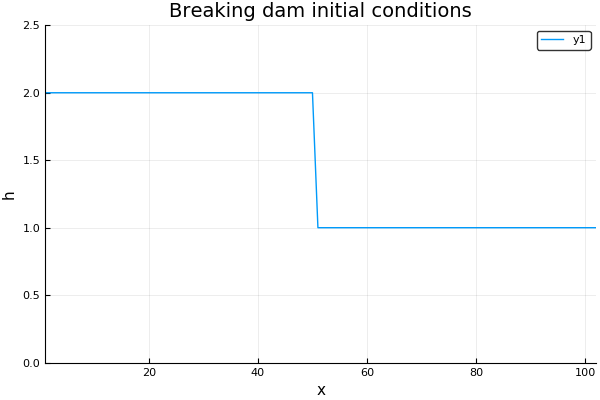

In [9]:
function breakingdam_ics(ncells::Int)
    [x < ncells/2+1 ? Q(2,0) : Q(1,0) for x in 1:ncells+2]
end

plotxh(breakingdam_ics(100), "Breaking dam initial conditions")

# Boundary Conditions

In [10]:

function outflow_bcs!(qs::Array{Q,1})
    qs[1] = qs[2]
    qs[end] = qs[end-1]
end

function periodic_bcs!(qs::Array{Q,1})
    qs[1] = qs[end-1]
    qs[end] = qs[2]
end


periodic_bcs! (generic function with 1 method)

# Lax-Friedrichs solutions

In [192]:
ncells = 100
t0 = 0
qs = breakingdam_ics(ncells)
Fl = Array{Q,1}(ncells+2)
Fr = Array{Q,1}(ncells+2)
a = @animate for t=1.0:40.0:4000.0
    qs,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, false, 1.0, outflow_bcs!)
    plotxh(qs, "Breaking Dam via Lax-Friedrichs")
end
anim23 = a

Plots.Animation("/var/folders/1k/q68xhskx4ks0dfs38lkh72y40000gn/T/tmpAQjav5", String["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

In [193]:
figure23 = gif(anim23, "animations/breakingdam_lxf.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/gaussian_in_time.gif


In [194]:
figure23

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/gaussian_in_time.gif")

* Breaking dam scenario with $t=4000, ncells=100, penalty=1.0$


# Lax-Friedrichs solutions

In [188]:
ncells = 100
t0 = 0
qs = gaussian_ics(ncells)
Fl = Array{Q,1}(ncells+2)
Fr = Array{Q,1}(ncells+2)
a = @animate for t=1.0:40.0:6000.0
    qs,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, true, 1.0, periodic_bcs!)
    plotxh(qs, "Gaussian via Lax-Friedrichs")
end
anim22 = a

Plots.Animation("/var/folders/1k/q68xhskx4ks0dfs38lkh72y40000gn/T/tmpQ0CtwU", String["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000141.png", "000142.png", "000143.png", "000144.png", "000145.png", "000146.png", "000147.png", "000148.png", "000149.png", "000150.png"])

In [199]:
figure22 = gif(anim22, "animations/gauss_lxf.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/gauss_lxf.gif


In [200]:
figure22

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/gauss_lxf.gif")

* Gaussian scenario with $t=6000, ncells=100, penalty=1.0$

# Effect of penalty term


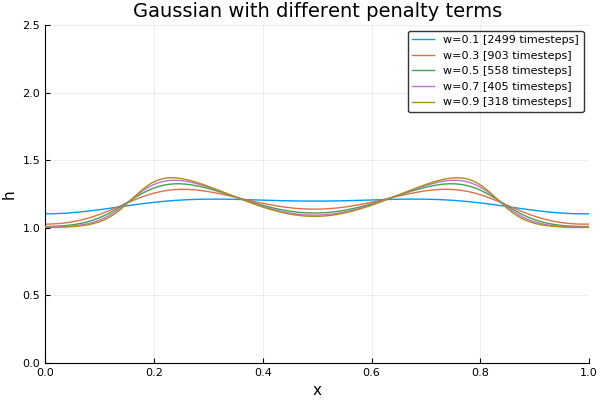

In [198]:
p = plotxh("Gaussian with different penalty terms")
for w = [0.1, 0.3, 0.5, 0.7, 0.9]
    qs,t,ts = run_experiment(600, 100, w, periodic_bcs!, gaussian_ics)
    plotxh!(p, qs, "w=$w [$ts timesteps]")
end
display(p)

# Effect of penalty term


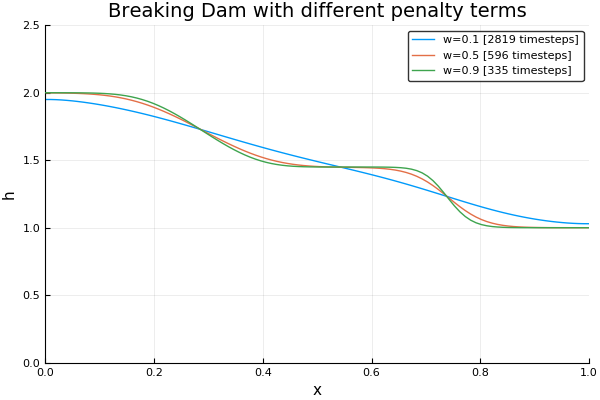

In [195]:
p = plotxh("Breaking Dam with different penalty terms")
for w = [0.1, 0.5, 0.9]
    qs,t,ts = run_experiment(600, 100, w, outflow_bcs!, breakingdam_ics)
    plotxh!(p, qs, "w=$w [$ts timesteps]")
end
display(p)

# Concept of Numerical Viscosity
* Show some math here, rearranging the Godunov to extract the viscous version

# Rusanov Idea
* Mathematical justification
* CFL condition constrains $\Delta x/\Delta t \geq \lambda_{max}$ 
* Show wave speed alongside height distribution


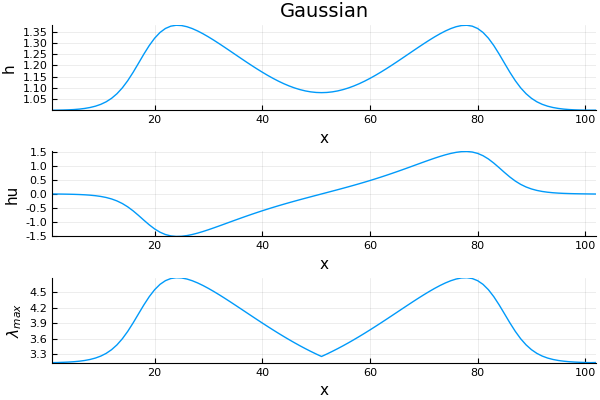

In [11]:
qs,t,ts = run_experiment(600, 100, 1.0, periodic_bcs!, gaussian_ics)
plotxhul(qs, "Gaussian")

# Local Lax Friedrich Implementation

In [12]:
function lxf!(qs::Array{Q,1}, Fl::Array{Q,1}, Fr::Array{Q,1}, ncells::Int,
              is_local::Bool, dx::Float, dt::Float)
    
    for x = 2:ncells+2

        ql, qr = qs[x-1], qs[x] 
        fl, fr = f(ql), f(qr)
        
        if is_local
            a = max(wavespeed(ql), wavespeed(qr))
        else
            a = dx/dt
        end
        
        Fr[x-1] = Q(0.5*((fr.h  - fl.h)  - a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) - a*(qr.hu - ql.hu)))
        Fl[x-1] = Q(0.5*((fr.h  - fl.h)  + a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) + a*(qr.hu - ql.hu)));
    end
    for x = 2:ncells+1
        q = qs[x]
        qs[x] = Q(q.h  - dt/ncells * (Fr[x].h  + Fl[x-1].h),
                  q.hu - dt/ncells * (Fr[x].hu + Fl[x-1].hu))
    end
end

lxf! (generic function with 2 methods)

# Updated timestepping loop

In [13]:
function run_experiment(stoptime, ncells::Int, is_local::Bool, safetyfactor::Float, 
                        apply_bcs!, apply_ics)

    qs = apply_ics(ncells)
    Fl = Array{Q,1}(ncells+2)
    Fr = Array{Q,1}(ncells+2)

    currenttime = 0
    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        lambda = maximum(map(wavespeed, qs))
        dt = cfl_dt(dx, lambda, safetyfactor)
        lxf!(qs, Fl, Fr, ncells, is_local, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment (generic function with 2 methods)

In [172]:
q1,t,ts = run_experiment(2000, 200, true,  0.3, outflow_bcs!, breakingdam_ics)
q2,t,ts = run_experiment(2000, 200, false, 0.3, outflow_bcs!, breakingdam_ics)
p = plotxh("Breaking Dam using LxF vs Local-LxF")
plotxh!(p, q1, "LLxF [$ts timesteps]")
plotxh!(p, q2, "LxF [$ts timesteps]")
figure1 = p;

# LxF vs Local-LxF on the Breaking Dam


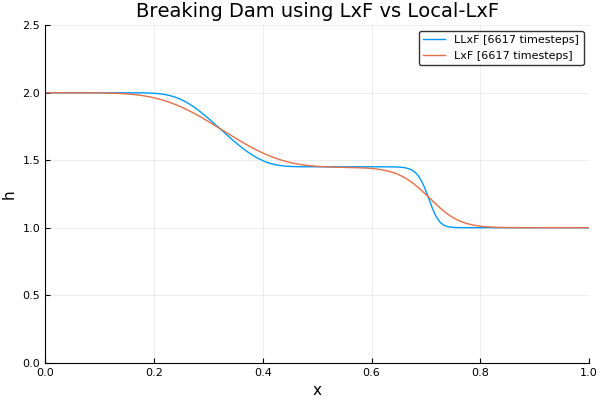

In [173]:
figure1

* Run breaking dam scenario with $t=2000, ncells=200, penalty=0.3$
* Local-Lax-Friedrich dissipates less than Lax-Friedrich, resulting in a less damped solution

In [174]:
q1,t,ts1 = run_experiment(2000, 200, true, 0.4, outflow_bcs!, breakingdam_ics)
q2,t,ts2 = run_experiment(2000, 200, true, 0.7, outflow_bcs!, breakingdam_ics)
q3,t,ts3 = run_experiment(2000, 200, true, 1.0, outflow_bcs!, breakingdam_ics)
q4,t,ts4 = run_experiment(2000, 200, false, 1.0, outflow_bcs!, breakingdam_ics)

p = plotxh("Breaking Dam comparison of LxF vs Local-LxF")
plotxh!(p, q1, "LLxF w=0.4 [$ts1 timesteps]")
plotxh!(p, q2, "LLxF w=0.7 [$ts2 timesteps]")
plotxh!(p, q3, "LLxF w=1.0 [$ts3 timesteps]")
plotxh!(p, q4, "LxF w=1.0 [$ts4 timesteps]")

figure2 = p;


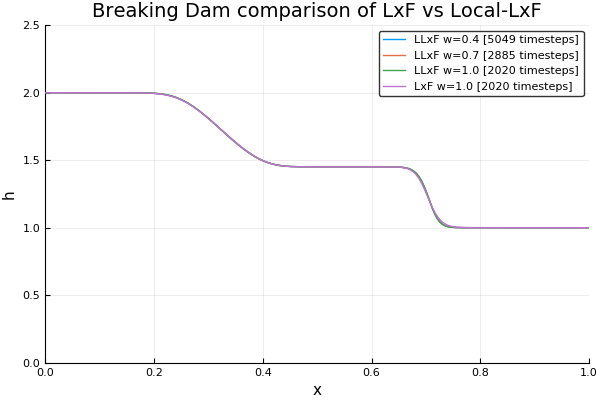

In [175]:
figure2

In [163]:
a = @animate for w = 0.1:0.1:1.0
    qll,t,tsl   = run_experiment(2000, 200, true, w, outflow_bcs!, breakingdam_ics)
    ql,t,ts   = run_experiment(2000, 200, false, w, outflow_bcs!, breakingdam_ics)
    p = plotxh("Breaking Dam comparison of LxF vs Local-LxF")
    plotxh!(p, qll, "LLxF w=$w")
    plotxh!(p, ql,  "LxF w=$w")
end
llxf_w_lt_1 = a;

In [176]:
figure3 = gif(llxf_w_lt_1, "animations/llxf_w_lt_1.gif", fps = 10);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/llxf_w_lt_1.gif


In [177]:
figure3

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/llxf_w_lt_1.gif")

When the penalty term $w < 1.0$,
* Lax-Friedrich damping affected by $w$
* Local-Lax-Friedrich damping is _not_ affected by $w$
* Local-Lax-Friedrich looks very similar to Lax-Friedrich with $w=1.0$

In [159]:
a = @animate for w = 1.0:2.0:46.0
    qll,t,tsl   = run_experiment(2000, 200, true, w, outflow_bcs!, breakingdam_ics)
    ql,t,ts   = run_experiment(2000, 200, true, 1.0, outflow_bcs!, breakingdam_ics)
    p = plotxh("Breaking Dam comparison of LxF vs Local-LxF")
    plotxh!(p, qll, "LLxF w=$w")
    plotxh!(p, ql,  "LLxF w=1.0")
end
llxf_w_gt_1 = a;


In [168]:
figure4 = gif(llxf_w_gt_1, "animations/llxf_w_gt_1.gif", fps = 10);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/llxf_w_gt_1.gif


In [169]:
figure4

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/llxf_w_gt_1.gif")

When the penalty term $w > 1.0$, 
* Local-Lax-Friedrich damping _is_ affected by $w$
* Lax-Friedrich damping becomes visibly unstable at $w > 2$
* Local-Lax-Friedrich becomes visibly unstable at $w > 40$

In [178]:
p = plotxh("Breaking Dam using LLxF with different penalty terms")
for w = [1.0, 40.0]
    qs,t,ts = run_experiment(2000, 200, true, w, outflow_bcs!, breakingdam_ics)
    plotxh!(p, qs, "w=$w [$ts timesteps]")
end
figure5 = p;


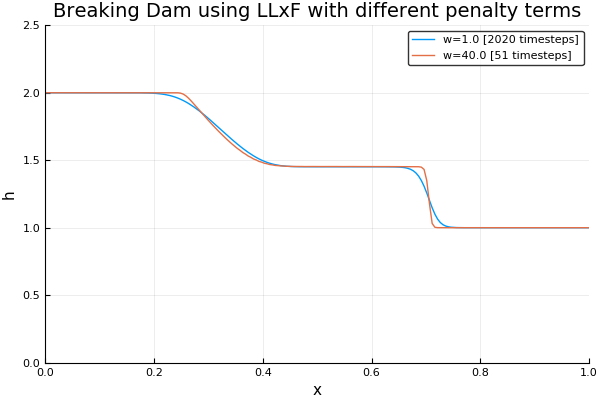

In [179]:
figure5

* Rarefaction wave is now sharp on the left, smooth on the right
* Consider separating viscosity penalty from timestep penalty

# Implementation Details -- Staircase instability from incorrect dt

* The existing code skeleton does not use the $\Delta t$ obtained from the CFL condition inside Lax-Friedrichs
* Instead, it uses the $\Delta t$ from the previous timestep
* The initial value $\Delta t_0 = 0.4\frac{ncells}{a_{adv}}$ where $a_{adv} = 0.25$
* This leads to a staircase instability:

In [202]:
function lxf_staircase!(qs::Array{Q,1}, Fl::Array{Q,1}, Fr::Array{Q,1}, 
              ncells::Int, dx::Float, dt::Float)
    
    a = dx/(1.6 * ncells)
    for x = 2:ncells+2
        ql, qr = qs[x-1], qs[x]
        fl, fr = f(ql), f(qr)
        
        Fr[x-1] = Q(0.5*((fr.h  - fl.h)  - a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) - a*(qr.hu - ql.hu)))
        Fl[x-1] = Q(0.5*((fr.h  - fl.h)  + a*(qr.h  - ql.h)),
                    0.5*((fr.hu - fl.hu) + a*(qr.hu - ql.hu)));
    end
    for x = 2:ncells+1
        q = qs[x]
        qs[x] = Q(q.h  - dt/ncells * (Fr[x].h  + Fl[x-1].h),
                  q.hu - dt/ncells * (Fr[x].hu + Fl[x-1].hu))
    end
end

lxf_staircase! (generic function with 1 method)

In [203]:
function run_experiment_staircase(stoptime, ncells::Int, safetyfactor::Float, 
                        apply_bcs!, apply_ics)

    qs = apply_ics(ncells)
    Fl = Array{Q,1}(ncells+2)
    Fr = Array{Q,1}(ncells+2)

    currenttime = 0
    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        lambda = maximum(map(wavespeed, qs))
        dt = cfl_dt(dx, lambda, safetyfactor)
        lxf_staircase!(qs, Fl, Fr, ncells, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment_staircase (generic function with 1 method)


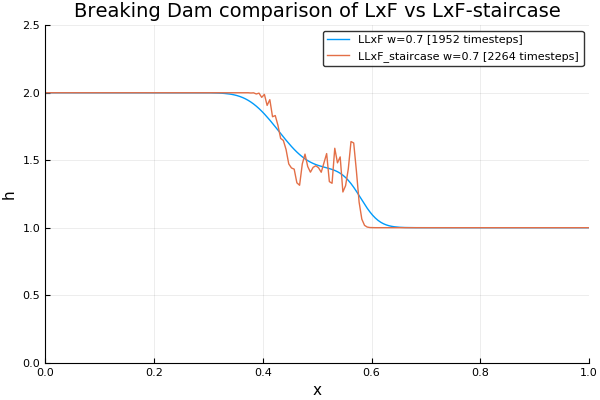

In [219]:
q1,t,ts1 = run_experiment(800, 200, 0.4, outflow_bcs!, breakingdam_ics)
q2,t,ts2 = run_experiment_staircase(800, 200, 0.4, outflow_bcs!, breakingdam_ics)

p = plotxh("Breaking Dam comparison of LxF vs LxF-staircase")
plotxh!(p, q1, "LLxF w=0.7 [$ts1 timesteps]")
plotxh!(p, q2, "LLxF_staircase w=0.7 [$ts2 timesteps]")
display(p)

# Implementation Details -- Spatial Discretization


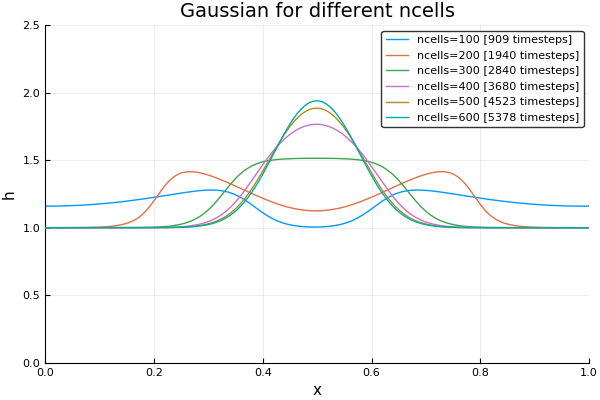

In [94]:
p = plotxh("Gaussian for different ncells")
for ncells = [100,200,300,400,500,600]
    qs,t,ts = run_experiment(2000, ncells, 1.0, periodic_bcs!, gaussian_ics)
    plotxh!(p, qs, "ncells=$ncells [$ts timesteps]")
end
display(p)

# Implementation Details -- Parallelization